In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
import skimage.io as io
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms, utils

In [2]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise
])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])

In [3]:
vgg = models.vgg16(pretrained=True)
# vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
def run_through_layer(x, layer):
    for j in range(layer):
        x = modulelist[j + 1](x)
    return x

In [21]:
v = Variable(preprocess(im).unsqueeze(0), requires_grad=True)
k = run_through_layer(v, 10)
print k[:, 0, :, :].shape

torch.Size([1, 56, 56])


In [22]:
def dd_helper(image, layer, iterations, lr):
    inp = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    vgg.zero_grad()
    
    # print inp.grad.data.shape
    
    for i in range(iterations):
        # out = vgg(inp)[:, 999]
        out = run_through_layer(inp, layer)[:, 0, :, :]
        
        loss = out.norm()
        loss.backward()
        inp.data = inp.data + lr * inp.grad.data
        # inp = inp.cuda()
        
    inp = inp.data.squeeze()
    inp.transpose_(0, 1)
    inp.transpose_(1, 2)
    inp = np.clip(deprocess(inp), 0, 1)
    im = np.uint8(inp * 255)
    
    return im

In [6]:
def deep_dream(image, layer, iterations, lr):
    img_res = dd_helper(image, layer, iterations, lr)
    img_res = resize(img_res, image.shape)
    
    # plt.imshow(img_res)
    return img_res

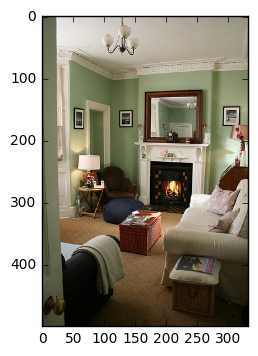

In [10]:
# im = io.imread('../../data/images/2007_000241.jpg')
im = io.imread('../../data/images/2007_000804.jpg')
# im = np.uint8(255*np.random.random((500, 500, 3)))
plt.imshow(im)

In [8]:
def plot_both(im1, im2):
    plt.figure(0, figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.subplot(1, 2, 2)
    plt.imshow(im2)

    plt.show()

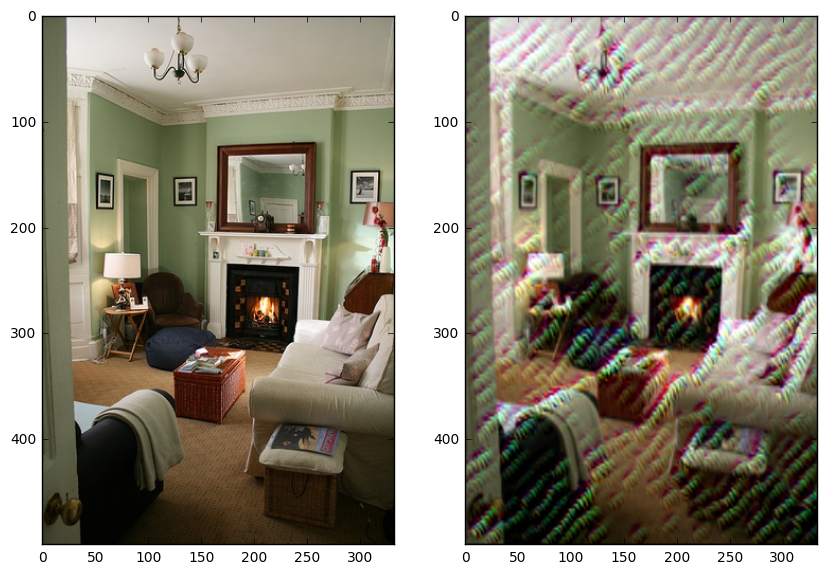

In [25]:
img = deep_dream(im, layer=10, iterations=10, lr=0.3)

plot_both(im, img)

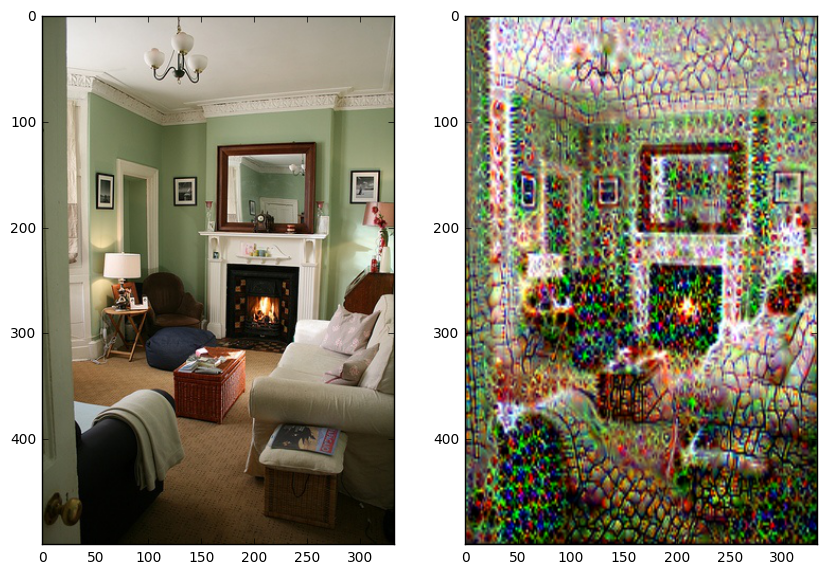

In [27]:
img2 = deep_dream(im, layer=15, iterations=10, lr=0.3)

plot_both(im, img2)